# CSE 519 HW3
## Tyler Estro (106929689), Noushin Salek Faramarzi (111687893), Tim Zhang (110746199)

# Initialization

In [3]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
import re
import math
import sklearn
from matplotlib import rcParams
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, LassoCV, RidgeCV, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics.pairwise import euclidean_distances
from scipy.stats import zscore
from IPython.display import Markdown, display

%matplotlib inline
import warnings
rcParams.update({'figure.autolayout': True})
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", module="pandas")

In [39]:
# Load dataset as data matrix X
X = pd.read_csv(open("properties_2017.csv", "rb"))

# Scoring Function

## Feature Selection and Imputation

One of the most important features of a house is size.  For this reason, we have selected a curated feature set involving mainly this attribute.  While size is an important attribute, the layout of a house is also very important.  Thus we also included properties of layout, such as the counts of bedrooms, bathrooms, and the size of garages.  Additionally, age seems to be an important aspect of a home so we include this feature as well.

We will consider the following features for our scoring function:
* 'bathroomcnt' 
* 'bedroomcnt'
* 'calculatedfinishedsquarefeet'
* 'taxamount'
* 'yearbuilt'
* 'basementsqft'
* 'garagetotalsqft' 
* 'buildingqualitytypeid'

In [40]:
scoring_features = X[['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'taxamount']]

We employ a custom imputation scheme.

* For each of the features in scoring_features we will use median imputation, since for of these domains the median seems to be a reasonable and robust method.

* For both basementsqft and garagetotalsqft, it seems a more reasonable assumption that if there is no record of these fields the property may simply not have a basement or a garage.  Thus we impute with a value of 0.

* Finally, ID based features should be imputed using the mode of the sample.  It seems reasonable that the most frequent ID in the dataset would continue to be most frequent.

In [41]:
imputed_scoring_features = scoring_features.fillna(scoring_features.median())
imputed_yearbuilt = X['yearbuilt'].fillna(X['yearbuilt'].median())
imputed_scoring_features['basementsqft'] = X['basementsqft'].fillna(0)
imputed_scoring_features['garagetotalsqft'] = X['garagetotalsqft'].fillna(0)
imputed_scoring_features['buildingqualitytypeid'] = X['buildingqualitytypeid'].fillna(X['buildingqualitytypeid'].mode()[0])

We create a custom 'age' feature by subtracting the current year by yearbuilt.

In [42]:
imputed_scoring_features['age'] = 2017 - imputed_yearbuilt

Next let's save our feature set for later analysis.

In [43]:
original_scoring_features = imputed_scoring_features.copy(deep=True)

## Exploratory Analysis and Cleaning

Next it seems prudent to plot the distributions of our features.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11669c6d0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x117184490>]], dtype=object)

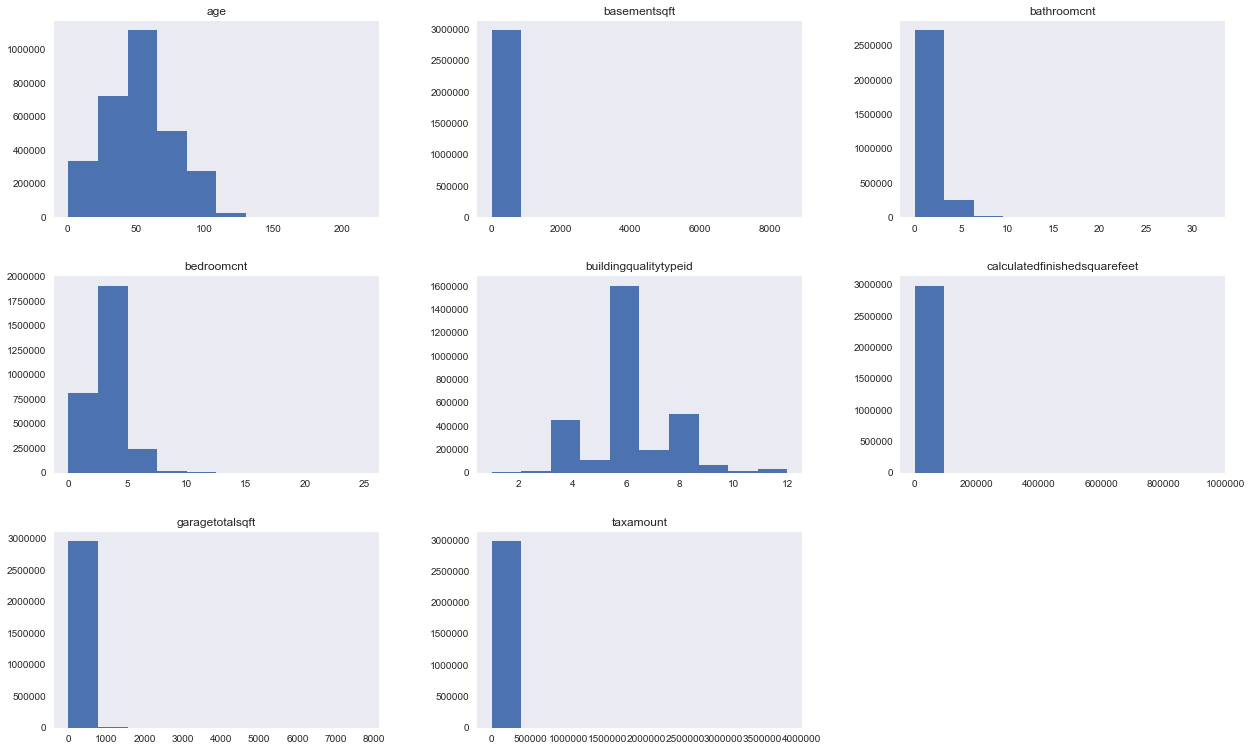

In [44]:
imputed_scoring_features.hist(grid=False)

Many of our plots seem uninfomative.  Let us try using a log-y plot.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1173e9350>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1125c2850>]], dtype=object)

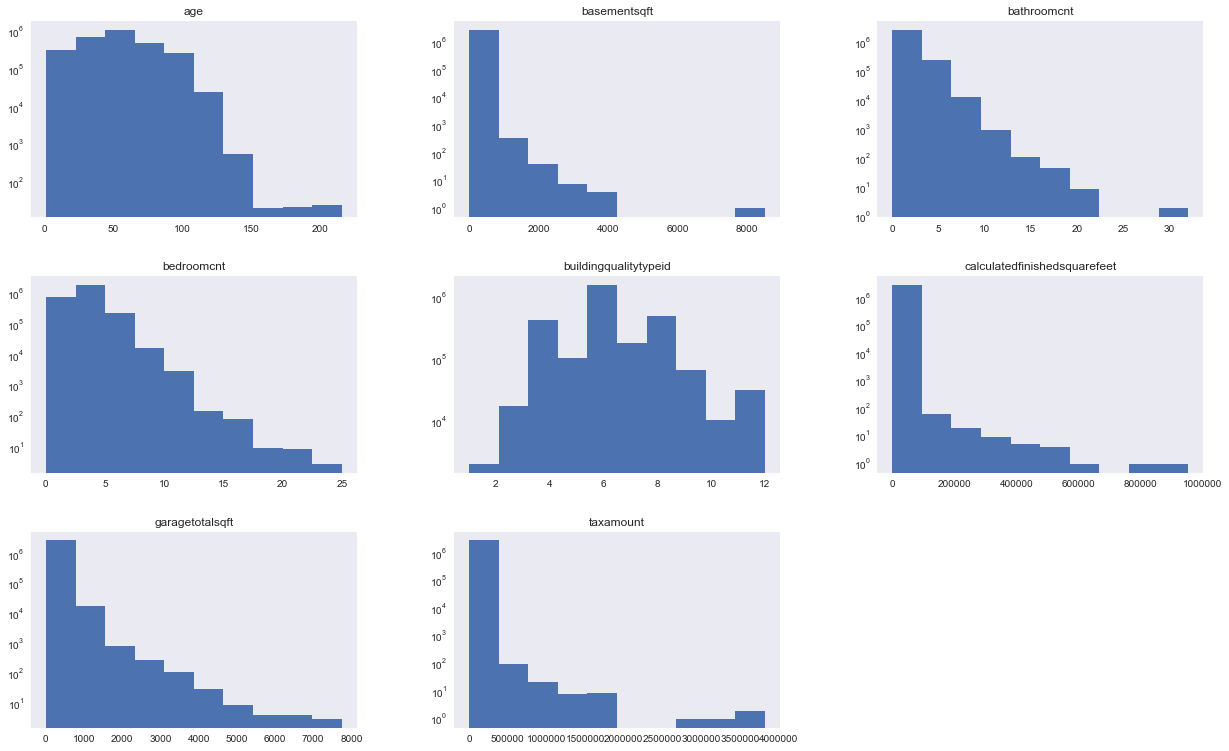

In [45]:
imputed_scoring_features.hist(log=True, grid=False)

Observing the plots above leads to an observation that some of the features seem to have heavy outliers.  In particular let us apply the log to 'basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', and 'taxamount'.

In [46]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']] = imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].apply(np.log).replace([np.inf, -np.inf], 0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115e9f150>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x115b19f10>]], dtype=object)

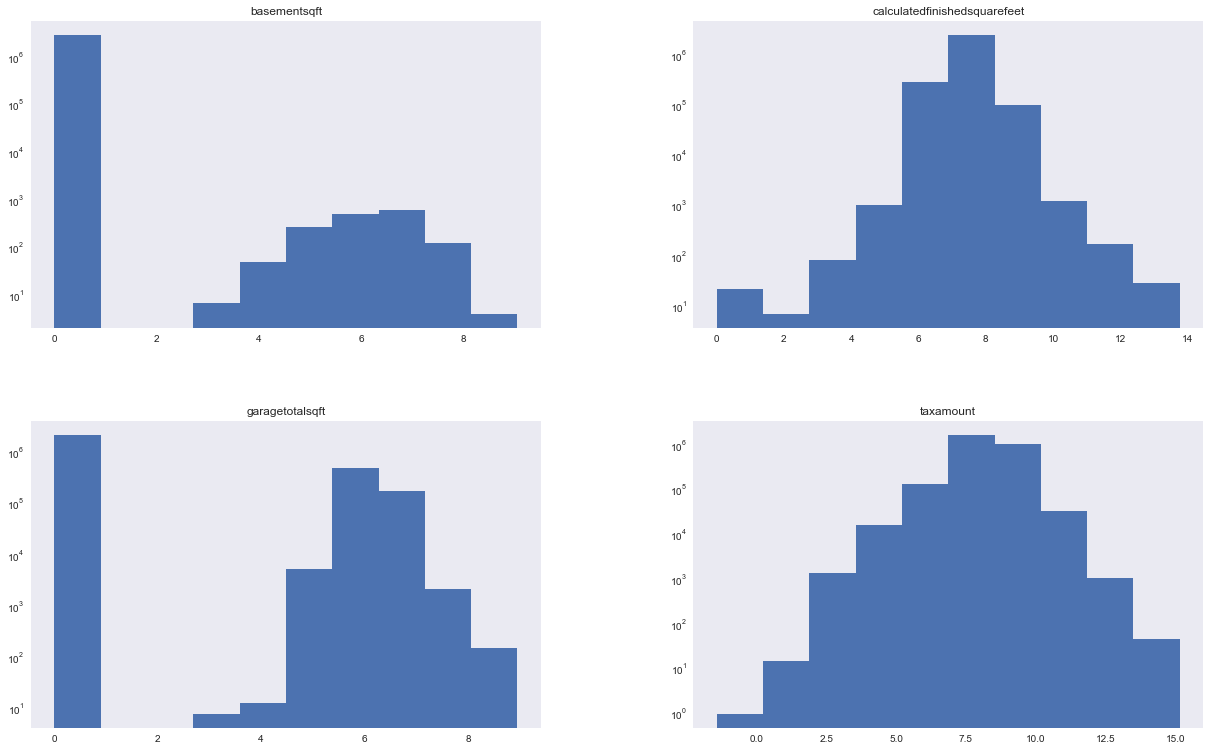

In [47]:
imputed_scoring_features[['basementsqft', 'calculatedfinishedsquarefeet', 'garagetotalsqft', 'taxamount']].hist(log=True, grid=False)

Plotting the above log-features shows roughly normally distributed values.  'basementsqft' and 'garagetotalsqft' both exhibit bimodal behavior due to the imputation strategy of 0-replacement.

Finally, let us apply z-score normalization to our entire feature matrix.

In [48]:
cleaned_scoring_features = imputed_scoring_features.apply(zscore)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1151b2210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x145565d90>]], dtype=object)

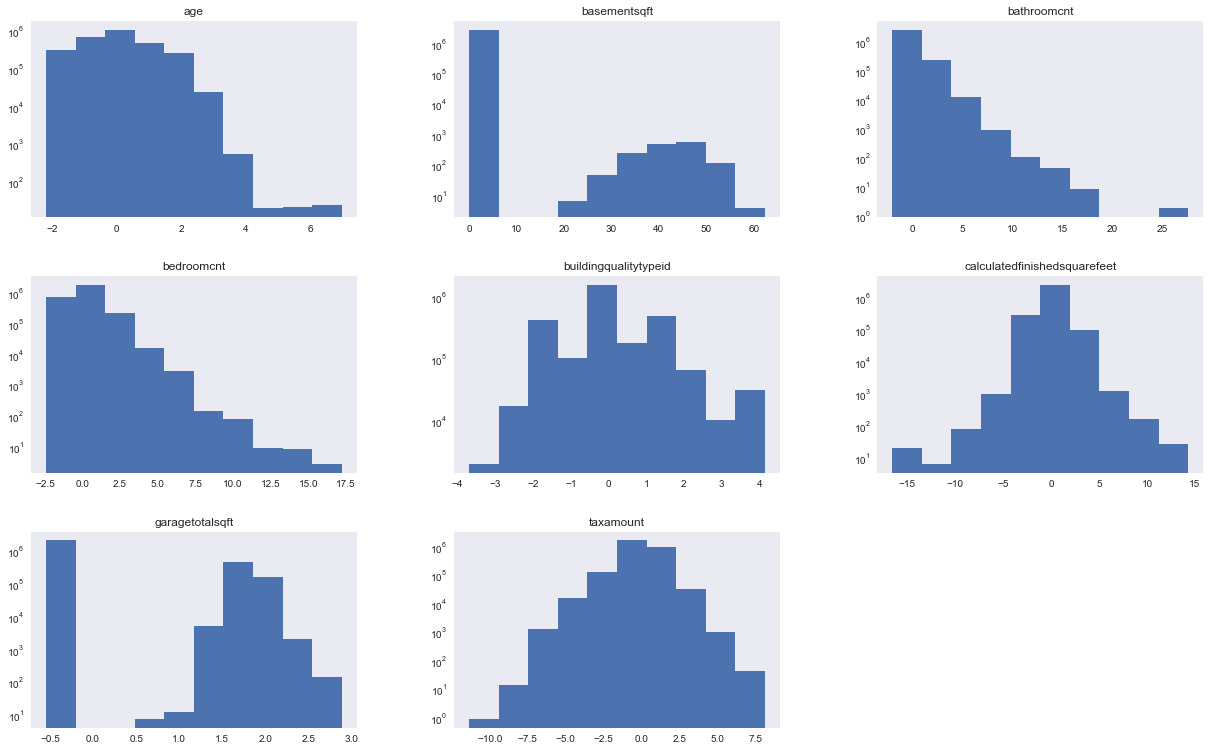

In [49]:
cleaned_scoring_features.hist(log=True, grid=False)

It seems that most of our features exhibit roughly symmetric normal empirical distributions.  We are now in a position to create a scoring function and rank our dataset.

## Scoring and Ranking

After z-score nomalization some of our data is still not conforming to a standard range.  To alleviate this we will apply the following weighted formulation as our scoring function: 

$- \text{age} + 0.1 \times \text{basementsqft} + 0.2 \times \text{bathroomcnt} + 0.5 \times \text{bedroomcnt} - \text{buildingqualitytypeid} + \text{calculatedfinishedsquarefeet} + 2 \times \text{garagetotalsqft} + \text{taxamount}$

Where we try to constrain the ranges within -10 and 10 and apply positive or negative weightings based on the features contribution to the score.  So for example, taxamount has a positive weighting since it reflects the assessment of value for your house and is generally a strong signal. 

In [50]:
scores = (-1 * cleaned_scoring_features['age']) + (.1 * cleaned_scoring_features['basementsqft']) + (.2 * cleaned_scoring_features['bathroomcnt']) - cleaned_scoring_features['buildingqualitytypeid'] + cleaned_scoring_features['calculatedfinishedsquarefeet'] + (2 * cleaned_scoring_features['garagetotalsqft']) + cleaned_scoring_features['taxamount'] 

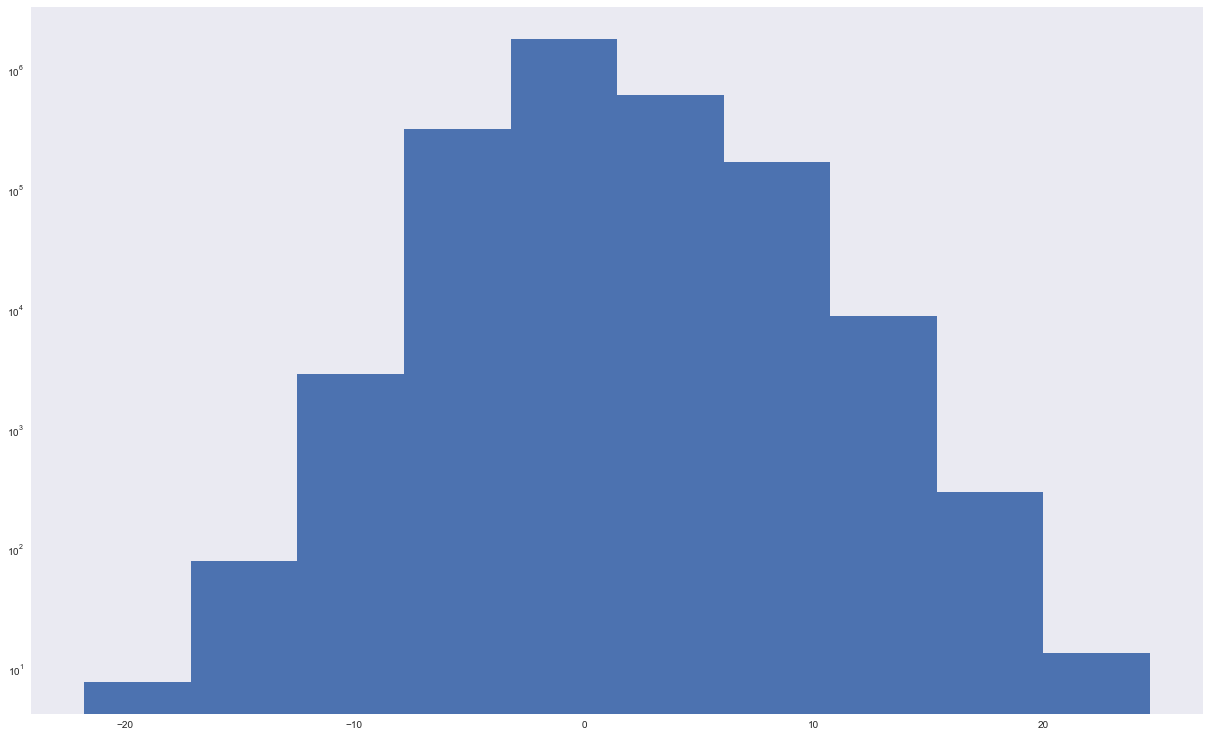

In [51]:
scores.hist(log=True, grid=False)

We find the ten most desirable houses to have the following scores:

In [52]:
print scores.nlargest(10)
high_keys = scores.nlargest(10).index.values

1520509    24.641774
254641     21.767707
342941     21.646459
1252741    21.406466
1041194    20.772267
432636     20.705109
1938915    20.698654
1133400    20.585368
2849244    20.551440
462377     20.474433
dtype: float64


We find the ten least desirable houses to have the following scores:

In [53]:
print scores.nsmallest(10)
low_keys = scores.nsmallest(10).index.values

1998676   -21.761091
1449989   -20.569205
2795091   -20.125434
80982     -18.850424
1768213   -17.930878
809346    -17.798545
1972644   -17.590825
2268215   -17.143430
1732202   -16.754876
2336074   -16.646185
dtype: float64


Using the fact that the indices were never permuted in our subsampling and cleaning, we can match row IDs to find the parcelid of the best residences.

In [54]:
print X['parcelid'][high_keys]

1520509    17291058
254641     17284931
342941     11746970
1252741    11984395
1041194    14324358
432636     11525376
1938915    11467277
1133400    10806423
2849244    17284897
462377     12560578
Name: parcelid, dtype: int64


The least desirable houses are as follows:

In [55]:
print X['parcelid'][low_keys]

1998676    12546681
1449989    11243663
2795091    12201284
80982      12186499
1768213    12586087
809346     11504997
1972644    11490532
2268215    10740889
1732202    10887059
2336074    12995195
Name: parcelid, dtype: int64


As a sanity check, let's print the imputed feature values for the best and worst houses.

Most desirable houses:

In [56]:
print original_scoring_features.iloc[high_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet   taxamount  \
1520509          9.5         6.0                       18117.0   283062.46   
254641           8.5         4.0                       12451.0    56903.60   
342941           0.0         0.0                      520825.0  3458861.12   
1252741          0.0         0.0                      472363.0  3277055.20   
1041194         14.5         9.0                       27100.0   179778.36   
432636           0.0         0.0                      512019.0  1548030.07   
1938915          0.0         0.0                      522511.0  1840935.06   
1133400          0.0         0.0                      454102.0  1757913.92   
2849244          9.0         4.0                       14003.0    86888.14   
462377           0.0         0.0                      617114.0  1030259.32   

         basementsqft  garagetotalsqft  buildingqualitytypeid   age  
1520509        8516.0           4000.0                    6.0  25.0  
2

Here we see that the most desirable houses indeed seem pretty desirable having large finished area, spacious basements and garages, and many bedrooms.  There are some properties which do not seem to be living areas per se, but are very large and have astronomical tax rates.

Least desirable houses:

In [57]:
print original_scoring_features.iloc[low_keys]

         bathroomcnt  bedroomcnt  calculatedfinishedsquarefeet  taxamount  \
1998676          0.0         1.0                           1.0     705.24   
1449989          0.0         0.0                           1.0     439.55   
2795091          1.0         3.0                           1.0     870.36   
80982            1.0         2.0                           1.0    1996.35   
1768213          3.0         1.0                           1.0    2020.66   
809346           2.0         5.0                           3.0    1676.86   
1972644          2.0         3.0                           1.0    4141.46   
2268215          2.0         3.0                           2.0    1134.93   
1732202          2.0         2.0                           7.0     650.99   
2336074          2.0         3.0                           2.0    2774.43   

         basementsqft  garagetotalsqft  buildingqualitytypeid    age  
1998676           0.0              0.0                    6.0   95.0  
1449989   

The very worst houses seem terrible with high taxes and almost no finished square feetage.  Additionally, these houses are very old.  However, it is quite possible that the 'calculatedfinishedsquarefeet' for these houses are input errors or due to some technicality.  It is also possible that these are historical properties given their age.

## Report

A key insight which we learned from designing the scoring function is that a simple heuristic statistic can capture real world phenomena quite accurately.  Many of the features present in the housing dataset are extraneous but may be used by Zillow to get a .0001 edge over the competition.  However, these features do not really add much to what an actual person would consciously consider when comparing properties.  

We chose to model the desirability of a house by what real people would consider: size, amenities, and age.  We also used the tax evaluation of the property, since this represents a strong signal as to what the property is really worth.  It could be argued that the tax evaluation would have served better as a proxy to test our function with.  However, it is our belief that by incorporating this important information our scoring function better captures "desirability".

It is true that location plays a large role in the desirability of a home.  However, there is no simple way to order all of the possible locations to make a quantitative statement about the contribution to a home's worth.  A way to incorporate such knowledge would require an entirely separate analysis of locations in Los Angeles and their relative rankings.  Since this seems to be a bit beyond the scope of this assignment, we chose to defer using locational data until comparisons can be made directly (using the key identifiers) in the distance function.

Although there is certainly room for improvement, our simple scoring function has withstood the sniff test.  It seems to really find some difference in the desirability of the properties that translates into a real world interpretation.  The best houses are spacious, with many bedrooms and other such luxeries.  The worst houses (according to the data) have a very low amount of finished square feetage and are also old with low tax evaluation.  It should be noted that many of the top tier houses may not be houses at all, which is reflected by their large finished area and high tax evaluation, but lack of bedrooms, bathrooms, etc.

While a ranking/scoring gives some insight into the data, we believe that there is another fundamental merit of this process.  To create a reasonable scoring function, one must take the time to consider the domain carefully.  It is through this process of consideration and data exploration that we can really begin to understand which variables really define our dataset.  This seems to be a very good general idea: slow down and consider the data before throwing it into a slew of machine learning algorithms.

# Distance Function

## Feature Selection

### Using the Scoring Function

To define our distance function we will take advantage of much of the heavy lifting we have already done and use the output of our scoring function as one feature for our distance measure.

In [58]:
print scores.nlargest(1).iloc[0] - scores.nsmallest(1).iloc[0]

46.402864407


We see that the difference potential between the largest and smallest scores is quite large.  We will need to normalize these values to be within $[0, 1]$.

In [59]:
z = scores.nlargest(1).iloc[0] - scores.nsmallest(1).iloc[0]  # Normalization constant

Let's test a few values to make sure that this works how we expect...

In [60]:
for x in range(0, 10):
    print abs(scores.sample(1).iloc[0] - scores.sample(1).iloc[0]) / z

0.0247394187298
0.044564824341
0.11649275568
0.0247286262189
0.175465952794
0.0600924743735
0.0236505521689
0.039718466869
0.0366545177083
0.0710123268768


Our values seem to be in the correct range, with most scored differences being relatively small.  To incorporate this function using builtin $l_2$ norm implementations we will normalize to $[0, 1]$.

In [61]:
scores = (scores - scores.nsmallest(1).iloc[0]) / z

### Incorporating Geography

To use geographic information we will take advantage of the longitude and latitude features in the dataset.

In [62]:
locations = X[['longitude', 'latitude']]

In [63]:
print locations.head()

     longitude    latitude
0 -118654084.0  34144442.0
1 -118625364.0  34140430.0
2 -118394633.0  33989359.0
3 -118437206.0  34148863.0
4 -118385816.0  34194168.0


Let us determine the percentages of missing data per location feature.

In [64]:
print 'longitude: ' + str(float(locations['longitude'].isnull().sum()) / locations.shape[0] * 100) + '%'
print 'latitude: ' + str(float(locations['latitude'].isnull().sum()) / locations.shape[0] * 100) + '%'

longitude: 0.0982173155251%
latitude: 0.0982173155251%


Next let us determine the range of our data.

In [65]:
print 'Range of longitude: ' + str(locations['longitude'].nlargest(1).iloc[0] - locations['longitude'].nsmallest(1).iloc[0])
print 'Range of latitude: ' + str(locations['latitude'].nlargest(1).iloc[0] - locations['latitude'].nsmallest(1).iloc[0])

Range of longitude: 1921464.0
Range of latitude: 1495262.0


In the context of geographical coordinates mean inputation seems reasonable since there should be little outliers to skew the data.

In [66]:
locations = locations.fillna(locations.mean())

Next let us normalize the longitude and latitude using $[0, 1]$ normalization.

In [67]:
locations['longitude'] = (locations['longitude'] - locations['longitude'].nsmallest(1).iloc[0]) / (locations['longitude'].nlargest(1).iloc[0] - locations['longitude'].nsmallest(1).iloc[0])
locations['latitude'] = (locations['latitude'] - locations['latitude'].nsmallest(1).iloc[0]) / (locations['latitude'].nlargest(1).iloc[0] - locations['latitude'].nsmallest(1).iloc[0])

In [68]:
locations.head()

,longitude,latitude
0,0.427641,0.548435
1,0.442588,0.545752
2,0.562668,0.444719
3,0.540512,0.551392
4,0.567257,0.581691


Finally, let's combine the scoring data with the location data into a new distance feature dataframe.

In [69]:
distance_features = locations[['longitude', 'latitude']].copy()
distance_features['score'] = scores.copy()

## Experiments

Next let us examine how the distances are distributed within a subset of the data.  Having selected which features will contribute to the distance we will utilize the standard Euclidean distance functio as our metric.

In [70]:
sample_size = 10000
subsample = distance_features.sample(sample_size)
distances = euclidean_distances(subsample)

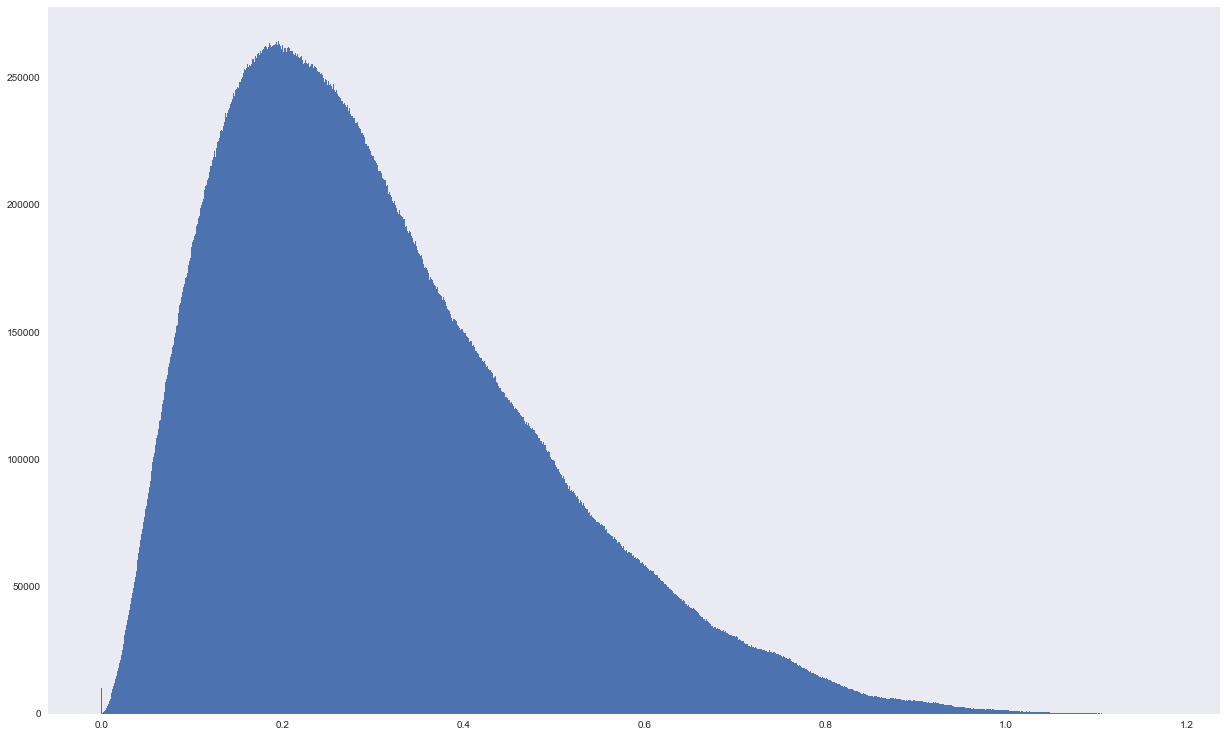

In [71]:
plt.hist(np.hstack(distances), bins='auto')
plt.axes().grid(False)
plt.show()

We observe a nice distribution of distances with most properties being different in some manner as expected of real data.

## Report

The process of determining good features for a distance metric is somewhat similar to that of choosing corresponding features for a scoring method.  In both cases one needs to critically evaluate the features in the data which contribute to the "definition" of being a representative object.  As we mentioned earlier, this process ultimately will lead to a stronger understanding of the problem space and hopefully lead to better models.

While there are many similarities in feature selection between scoring and distance, there is a clear difference in the interpretation of the numerical output we achieve.  Given the fact that our eventual goal is to cluter the dataset using our distance function, we needed to constrain the range of values that a feature can contribute.

To achieve this normalization we observed that dividing each score by the range lead to desirable results.  After normalization the score difference was constrained to be $1$ only when the best and worst properties were compared, and positive $\lt 1$ otherwise.  We also needed to constrain the geographical feature range, since the original representation was in the tens to hundreds of millions.  Our approach to normalizing the geographical data was byb using mean imputation and $[0, 1]$ normalization.  We thought that mean imputation was a reasonable approach given the nature of the geographical data.

Having cleaned and normalized our data we then experimented via random subsampling of the data matrix $X$.  We used the Euclidean distance metric as our distance function as our clustering algorithm of choice is k-means.  The theoretical properties of k-means require that Euclidean distance is used for proper convergence.  As shown above, we found that the empirical distribution of distances was very satisfactory.  Most properties were dissimilar, with ranges smoothly transitioning between those which were more dissimilar than others.

Prior to testing our distance function with clustering we had many failed iterations.  In the first case we tried using regionid based locations and creating a custom distance function by boolean comparison.  However, this approach did not work since efficient clustering implementations required a directly comparable Euclidean computation.  After choosing longitude and latitude as our geographical features, we also met failure by improperly normalizing our data using z-scores.  The z-score normalization lead to imbalanced distance features where the geographical attributes dominated the clusters.  Thus we had partitioned the data into regions, which is not entirely interesting as we wish to also observe "desirability" scores as well.

# Clustering

For our clustering analysis we will impose our cluster classes onto the scatter plot of longitude and latitude.

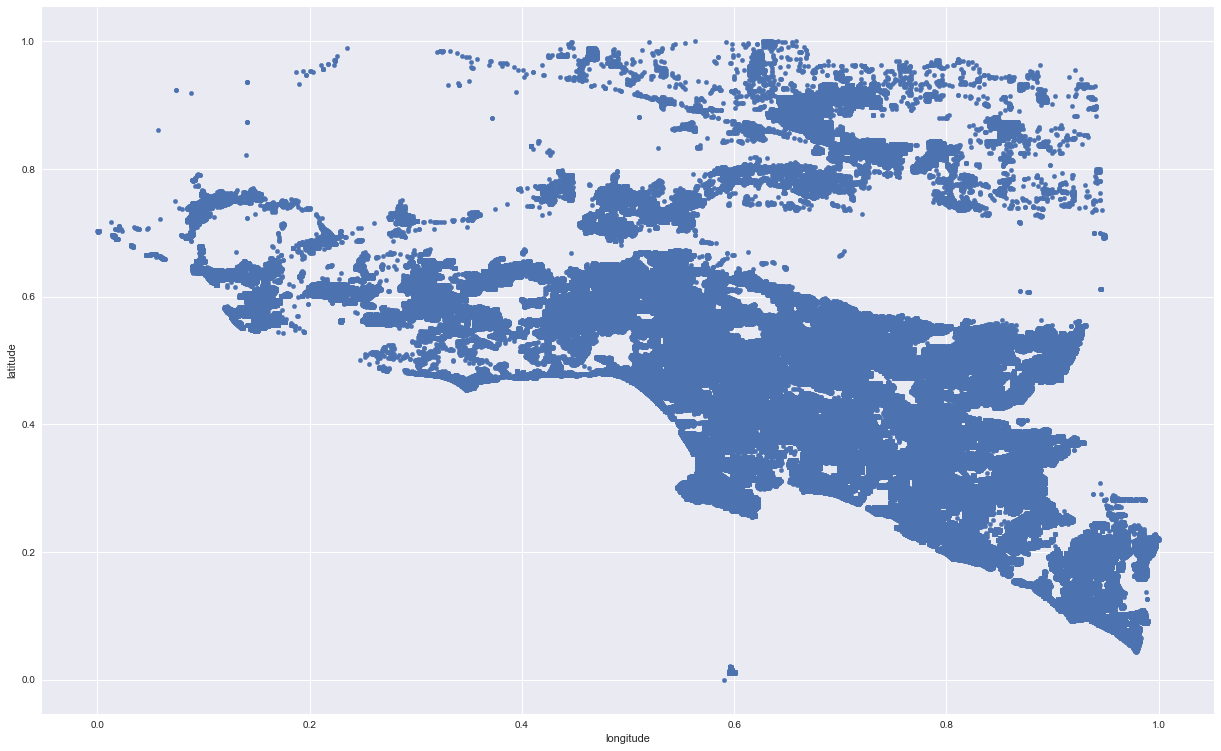

In [72]:
locations.plot(kind='scatter', x='longitude', y='latitude')

## Experiments

### k = 10

In [73]:
km = sklearn.cluster.KMeans(n_clusters=10)
km.fit(distance_features.as_matrix())
labels = km.labels_

In [74]:
results = pd.DataFrame(data=labels, columns=['cluster'], index=distance_features.index)

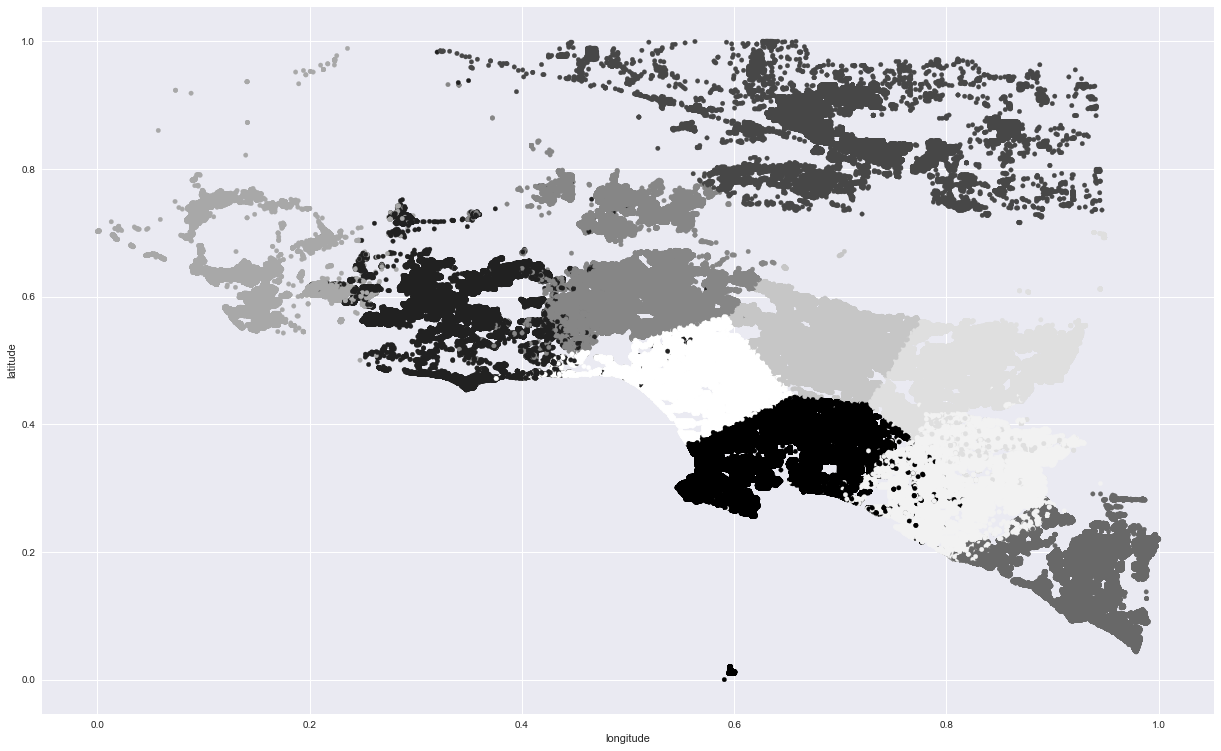

In [75]:
locations.plot(kind='scatter', x='longitude', y='latitude', c=(results['cluster'] * 100))

It seems that $k=10$ is a little too coarse of a clustering and mostly clusters by geographic location.

### k = 25

In [76]:
km = sklearn.cluster.KMeans(n_clusters=25)
km.fit(distance_features.as_matrix())
labels = km.labels_

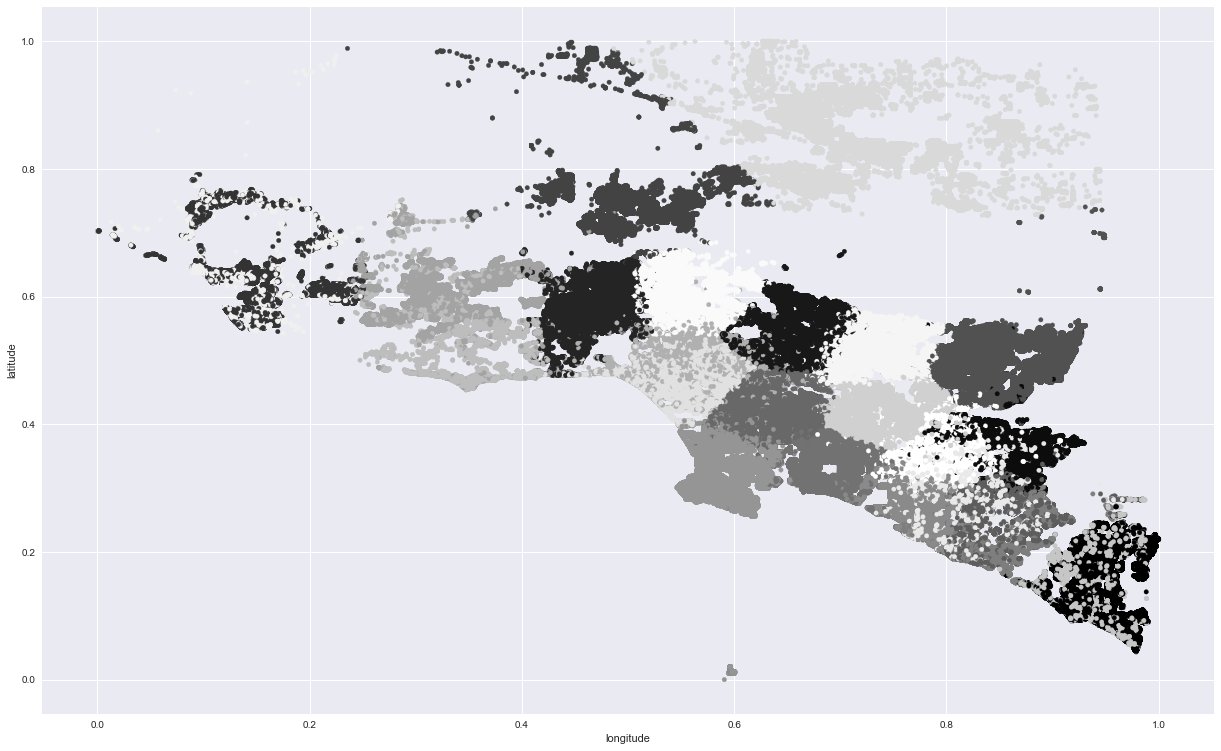

In [77]:
results = pd.DataFrame(data=labels, columns=['cluster'], index=distance_features.index)
locations.plot(kind='scatter', x='longitude', y='latitude', c=(results['cluster'] * 100))

Using $k=25$ we see more clusters formed not only via geography.

## Report

To achieve clusters of our data we used the k-means algorithm.  Due to our choice of distance features we see that our clustering results reflect both geographical data as well as our scoring function.  We can see that our scoring function has a role in the results by examining the "pollution" between clusters which would otherwise make for fine geographical lines.  The effect of our scoring function is muted in the case of $k=10$ however one may still see the mixing phenomena which represents that some properties are more similar to other properties in a farther geographic region than the surrounding space.

We were not entirely pleased with the results of $k=10$ however.  The cluster centroids seemed to be heavily influenced by geographical proximity rather than "desirability".  Thus we tried the parameter of $k=25$ to try and gain more definition.  The logic is that if there are more clusters the geographical proximity measure must be dilluted in such a way that the total area of any single cluster would be reduced.  Indeed by examining our result for $k=25$ we see that many geographical regions have multiple cluster mixtures.  This implies that many of the houses can be partitioned via our "desirability" scores.

It is a good grounding check that geographical region does play a large role in the clustering.  This should be the case as our distance metric is more heavily weighted towards geography ($2/3$ of the features are geographical).  The different mixtures in the $k=25$ case shows that there is a real difference in the size, tax evaluation, and etc between a single contiguous area.  This distinction was not represented in the $k=10$ test.

We decided to stop at $k=25$ since any futher increase in cluster size would make the data less interpretable.  We have already teased out regions in space which are of interest and noted real world correspondences in the data to our intuition.

# External Dataset Integration

For this part of the challenge, we've been provided with an additional training set that includes more entries, as well as the most recent transactions for some properties in the old set. To make the best use of these sets, we'll merge them together and keep only the most recent transaction for all properties

In [ ]:
# combining training sets to have one set with the most recent values
train16 = pd.read_csv('train_2016_v2.csv')
train17 = pd.read_csv('train_2017.csv')
train = train16.merge(train17, how='outer', on='parcelid')
train['logerror_y'] = train['logerror_y'].fillna(train['logerror_x'])
train['transactiondate_y'] = train['transactiondate_y'].fillna(train['transactiondate_x'])
train = train.drop(['logerror_x','transactiondate_x'], axis=1)
train.columns = ['parcelid','logerror','transactiondate']
train.to_csv('train_combined.csv', index=False)

We've also been provided with a new properties dataset that includes more information on several of the properties. We'll read in this new set instead, along with the combined version of the training data.

In [4]:
# reading in Zillow's data
props = pd.read_csv('properties_2017.csv', low_memory=False)
train = pd.read_csv('train_combined.csv')

## Geocoding Location

When examining some of the location-based data in the properties_2017 dataset, it seems that "regionidzip" does not represent the actual U.S. Postal Zip Code. If we want to integrate location-based data into our properties data set, we'll have to find a solution to this. We still have latitude and longitude to work with, but it would be extremely cumbersome to manipulate ~3 million x 2 coordinate values. 

After doing some research on how to solve this problem, there appears to be a process called **geocoding** where you can send an address or other location data to a web-based service and they will send back coordinates and potentially other data. There's also a process called **reverse geocoding** where you can do the reverse, sending the coordinates and receiving an address. Since we have the coordinates for each property, we can utilize this reverse geocoding to retrieve the zip codes for each of them. The dilemma here is that we have ~3 million properties and all of the free geocoding services limit your queries to some number of 1000's per day.

In an attempt to remedy this problem, let's first view how many unique regionidzip values we have.

In [4]:
print('Unique regionidzip values: ' + str(len(props['regionidzip'].unique())) + '.')

Unique regionidzip values: 404.


Since we only have 404 unique values, we can certainly use a geocoding service such as Google on these. We'll grab a set of coordinates associated with each unique regionidzip, then reverse geocode them to create a mapping between regionidzips and actual U.S. Postal Zip Codes.

In [ ]:
# this function performs a reverse geocode using Google to obtain postal zip codes from coordinates
def find_zip(row):
    try:
        return geocoder.google([row['latitude'], row['longitude']], method='reverse').postal
    except ValueError:
        return np.nan

# this dataframe will function as a dictionary between regionidzip and postal zip codes
zip_df = pd.DataFrame(props['regionidzip'].unique(), columns=['regionidzip']).dropna().reset_index(drop=True)
zip_df['ZIP'] = pd.Series()
zip_df['latitude'] = pd.Series()
zip_df['longitude'] = pd.Series()

# finding a lat/long for each unique regionidzip
for x in zip_df.index:
    temp_df = pd.DataFrame(props.loc[props['regionidzip'] == zip_df.iloc[x][0]], columns=props.columns)
    # apparently the zillow people are comedians and multiply their coordinates by 1 million
    zip_df.at[x, 'latitude'] = np.round(temp_df.iloc[0]['latitude'] / 1000000, 8)
    zip_df.at[x, 'longitude'] = np.round(temp_df.iloc[0]['longitude'] / 1000000, 8)

# applying the reverse geocoding function to populate the ZIP column
zip_df.apply(lambda row: find_zip(row), axis=1)

# had to run this a few times to make up for google throttling me
for x in zip_df.index:
    if zip_df.iloc[x]['ZIP'] == None:
        zip_df.at[x, 'ZIP'] = find_zip(zip_df.iloc[x])

# google gave up on me so I manually looked these two up
zip_df.at[137, 'ZIP'] = 91789
zip_df.at[389, 'ZIP'] = 93013

# don't need these coordinates anymore
zip_df = zip_df.drop(['latitude','longitude'], axis=1)
zip_df.to_csv('id_to_zip.csv', index=False)

Now that we have this dictionary, we can easily translate all properties regionidzip into a new column containing the real zip codes. Then we'll be ready to begin integrating external datasets.

In [5]:
# adding geocoded zip codes to the props dataframe
zip_df = pd.read_csv('id_to_zip.csv')
props2 = props
props2['ZIP'] = pd.Series(index=props.index)
zip_ar = np.where(props['regionidzip'] == zip_df.iloc[0]['regionidzip'], zip_df.iloc[0]['ZIP'], props2['ZIP'])
for x in zip_df.index[1:]:
    zip_ar = np.where(props['regionidzip'] == zip_df.iloc[x]['regionidzip'], zip_df.iloc[x]['ZIP'], zip_ar)
zip_df2 = pd.DataFrame(zip_ar, columns=['ZIP'])
props2['ZIP'] = zip_df2['ZIP']

# Dataset #1

## CalEnviroScreen 3.0

Our first external dataset comes from https://data.ca.gov/dataset/calenviroscreen-30. This is a government data set that is designed to help identify California communities that are burdened by multiple sources of pollution. For each zip code, it includes several sources of pollution, but also other variables such as unemployment, poverty, and health-relted variables. It is our belief that these factors have a significant impact on property value, so hopefully we will see some decent correlations with logerror.

We can see that there are generally two types of each variable in the dataset, a scored variable in the form of some numerical value, and ranked variable in the form of a percentage relative to all other locations. Since we are comparing properties in relation to each other, it would be better to work with the percentiles. We can also see that many zip codes have several entries, since the census gathers this information in chunks and store them in separate "tracts". In this case, we'll take the means of all their values and use them to represent the zip code.

To begin integrating this dataset, we first have to do some cleaning so that we can extract and then merge data specifically from zip codes in the 3 counties we are concerned with.

In [6]:
# reading in the first external data set
env = pd.read_excel('cali_env3.xlsx')

# set had spaces after these county names
env = env.replace(to_replace='Orange ', value='Orange')
env = env.replace(to_replace='Ventura ', value='Ventura')

# grabbing percentiles, dropping NANs, and taking the mean where multi similar zips exists
# there are censustract's which span multiple points in the same zip code
env_la = env.loc[env['California County'] == 'Los Angeles'].select(lambda x: re.search('Pctl', x), axis=1)
env_la['ZIP'] = env.loc[env['California County'] == 'Los Angeles']['ZIP']
env_la = env_la.dropna()
env_la2 = pd.DataFrame(columns=env_la.columns)
for x in env_la['ZIP'].unique():
    env_la2 = env_la2.append(np.round(env_la.loc[env['ZIP'] == x].mean(), 4), ignore_index=True)
env_la2['County'] = 'Los Angeles'

# Orange and Ventura county entries contain a space after the name
env_or = env.loc[env['California County'] == 'Orange'].select(lambda x: re.search('Pctl', x), axis=1)
env_or['ZIP'] = env.loc[env['California County'] == 'Orange']['ZIP']
env_or = env_or.dropna()
env_or2 = pd.DataFrame(columns=env_or.columns)
for x in env_or['ZIP'].unique():
    env_or2 = env_or2.append(np.round(env_or.loc[env['ZIP'] == x].mean(), 4), ignore_index=True)
env_or2['County'] = 'Orange'
    
env_ve = env.loc[env['California County'] == 'Ventura'].select(lambda x: re.search('Pctl', x), axis=1)
env_ve['ZIP'] = env.loc[env['California County'] == 'Ventura']['ZIP']
env_ve = env_ve.dropna()
env_ve2 = pd.DataFrame(columns=env_ve.columns)
for x in env_ve['ZIP'].unique():
    env_ve2 = env_ve2.append(np.round(env_ve.loc[env['ZIP'] == x].mean(), 4), ignore_index=True)
env_ve2['County'] = 'Ventura'
    
# adding all the frames together
env2 = pd.concat([env_la2, env_or2, env_ve2], ignore_index=True)

# dropping duplicate zip code entries
env2 = env2.drop_duplicates(subset=['ZIP'])
env2 = env2.reset_index(drop=True)

# zip codes shouldnt be floats
env2['ZIP'] = env2['ZIP'].astype(np.int64)

Now that we've cleaned up our data set, let's view the data dictionary provided in a separate Excel sheet so we can understand what all of the included variables represent.

In [7]:
env_dict = pd.read_excel('cali_env3.xlsx', sheetname='Data Dictionary')
for x in np.array(list(map(lambda x: re.sub(r'(.+) Pctl', r'\1', x), env2.drop(['ZIP','County'], axis=1).columns))):    
    display(Markdown('**' + str(x) + ":** " + 
                     env_dict.loc[env_dict['Variable Name'] == x]['Description'].values[0] + '\n'))

**Ozone:** Amount of daily maximum 8 hour Ozone concentration 


**PM2.5:** Annual mean PM 2.5 concentrations


**Diesel PM:** Diesel PM emissions from on-road and non-road sources


**Drinking Water:** Drinking water contaminant index for selected contaminants


**Pesticides:** Total pounds of selected active pesticide ingredients (filtered for hazard and volatility) used in production-agriculture per square mile in the census tract


**Tox. Release:** Toxicity-weighted concentrations of modeled chemical releases to air from facility emissions and off-site incineration (from RSEI)


**Traffic:** Traffic density, in vehicle-kilometers per hour per road length, within 150 meters of the census tract boundary


**Cleanup Sites:** Cleanup sites, sum of weighted EnviroStor cleanup sites within buffered distances to populated blocks of census tracts


**Groundwater Threats:** Groundwater threats, sum of weighted GeoTracker leaking underground storage tank sites  within buffered distances to populated blocks of census tracts


**Haz. Waste:** Sum of weighted hazardous waste facilities and large quantity generators within buffered distances to populated blocks of census tracts


**Imp. Water Bodies:** Impaired water bodies, sum of number of pollutants across all impaired water bodies within buffered distances to populated blocks of census tracts


**Solid Waste:** Sum of weighted solid waste sites and facilities (SWIS) within  buffered distances to populated blocks of census tracts


**Pollution Burden:** Average of percentiles from the Pollution Burden indicators (with a half weighting for the Environmental Effects indicators)


**Asthma:** Age-adjusted rate of emergency department visits for asthma


**Low Birth Weight:** Percent low birth weight


**Cardiovascular Disease:** Age-adjusted rate of emergency department visits for heart attacks per 10,000


**Education:** Percent of population over 25 with less than a high school education


**Linguistic Isolation:** Percent limited English speaking households


**Poverty:** Percent of population living below two times the federal poverty level


**Unemployment:** Percent of the population over the age of 16 that is unemployed and eligible for the labor force


**Housing Burden:** Percent housing burdened low income households


**Pop. Char.:** Average of percentiles from the Population Characteristics indicators


It's now time to merge these two datasets. We want to utilize them for our main objective, which is predicting logerror, so we'll also merge them together with the combined training set we created earlier.

In [7]:
# merging the environmental data into the set
props3 = props2.merge(env2, on='ZIP', how='left')
# merging with the training to gain a set with logerrors for corr analysis
props4 = train.merge(props3, how='left', on='parcelid')

A good start to analyzing the relationships between these variables and the logerror would be to examine their correlations with a heatmap. Let's focus only on the logerror and environmental variables, and exclude property variables from this visualization.

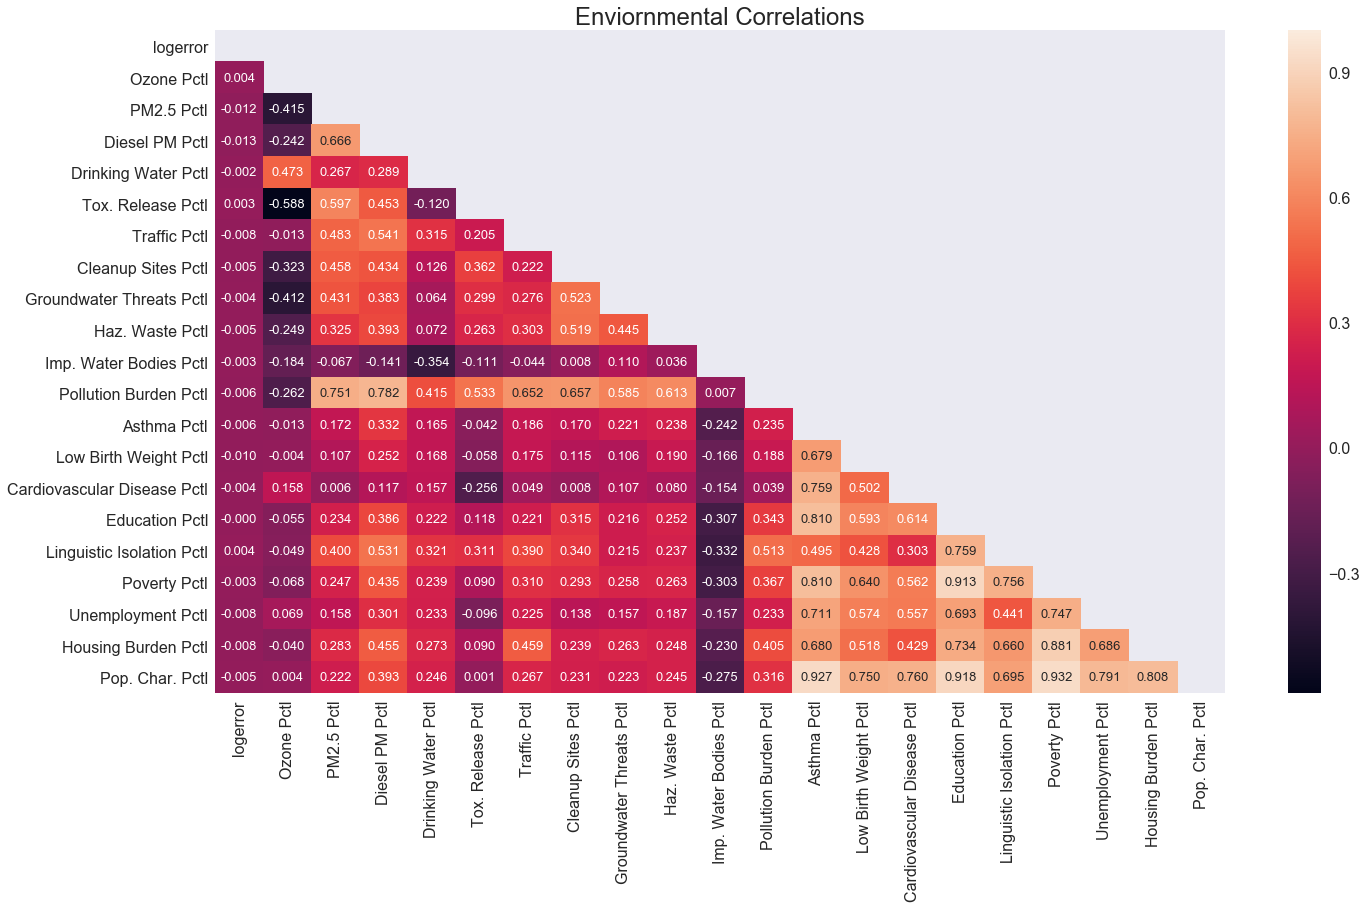

In [332]:
# dropping prop values so we can only see how environmental variables correlate with logerror
props4 = props4.drop(props.columns, axis=1)
props4 = props4.drop(['County'], axis=1)

df_corr = props4.select(lambda x: not re.search('id', x), axis=1).corr()

# masking the upper right triangle of the heatmap
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# building heatmap
sns.set(font_scale=1.6)
heatmap = sns.heatmap(df_corr, mask=mask, annot=True, fmt=".3f", annot_kws={"size": 13},
                      xticklabels=True,yticklabels=True)
heatmap.set_title("Enviornmental Correlations", fontsize=24)
heatmap.figure.set_size_inches(21, 13)

As to be expected, we only see very weak correlations between the logerror and any of the variables. However, it's also interesting to see the correlation between poverty and linguistic isolation, or asthma and diesel emissions. This heatmap should be sufficient to select a few variables that might be useful in a prediction model. 

# Dataset #2

## California Demographics

The second dataset we will integrate comes from https://data.ca.gov/dataset/california-population-projection-county-age-gender-and-ethnicity. This set contains demographic information gathered from the census indicating the estimated population of all California counties categorized by age, gender, race and ethnicity. For this dataset we'll primarily be concerned with the racial and ethnic population of each county, so we'll consolidate the age and gender categories into a single sum per race and ethnicity.

The census categorizes population as a hispanic race or non-hispanic race (eg. hispanic white and non-hispanic white), so we will represent this by prefixing all race labels with "H" or "NH".

A convenient consequence of integrating the previous dataset was that we were also able to attach the county each property is located in as we translated the zip codes. The demographics dataset does not include zip codes, but it includes county information. This will allow us to integrate with the properties data set, albeit with much less precision than by zip code. Similar to the last data set, we'll also take the percentiles of each category since they are relative to each other and the total population.

In [8]:
demo = pd.read_csv('cali_demo.csv')
demo = demo.loc[demo['YEAR'] == 9] # 2016
demo = demo.loc[demo['AGEGRP'] == 0] # includes all ages
demo = demo.loc[(demo['CTYNAME'] == 'Los Angeles County') | (demo['CTYNAME'] == 'Orange County') |
                    (demo['CTYNAME'] == 'Ventura County')]
demo2 = pd.DataFrame(columns=['NH White','H White','NH Black','H Black','NH Asian','H Asian',
                                    'NH Native','H Native','NH Hawaiian','H Hawaiian',
                                    'NH Two+','H Two+'])
demo2['County'] = demo['CTYNAME']
demo2 = demo2.replace(to_replace='(.+) County', value=r'\1', regex=True)
demo2 = demo2.reset_index(drop=True)

# consolidating gender, then calculating percentiles
for x in demo2.index:
    demo2.at[x, 'NH White'] = np.round((demo.iloc[x][['NHWAC_MALE','NHWAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H White'] = np.round((demo.iloc[x][['HWAC_MALE','HWAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'NH Black'] = np.round((demo.iloc[x][['NHBAC_MALE','NHBAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H Black'] = np.round((demo.iloc[x][['HBAC_MALE','HBAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'NH Asian'] = np.round((demo.iloc[x][['NHAAC_MALE','NHAAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H Asian'] = np.round((demo.iloc[x][['HAAC_MALE','HAAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'NH Native'] = np.round((demo.iloc[x][['NHIAC_MALE','NHIAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H Native'] = np.round((demo.iloc[x][['HIAC_MALE','HIAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'NH Hawaiian'] = np.round((demo.iloc[x][['NHNAC_MALE','NHNAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H Hawaiian'] = np.round((demo.iloc[x][['HNAC_MALE','HNAC_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'NH Two+'] = np.round((demo.iloc[x][['NHTOM_MALE','NHTOM_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)
    demo2.at[x, 'H Two+'] = np.round((demo.iloc[x][['HTOM_MALE','HTOM_FEMALE']].sum().sum() / demo.iloc[x]['TOT_POP']) * 100, 8)

To get an idea of how diverse each county is, we'll plot the distribution per county.

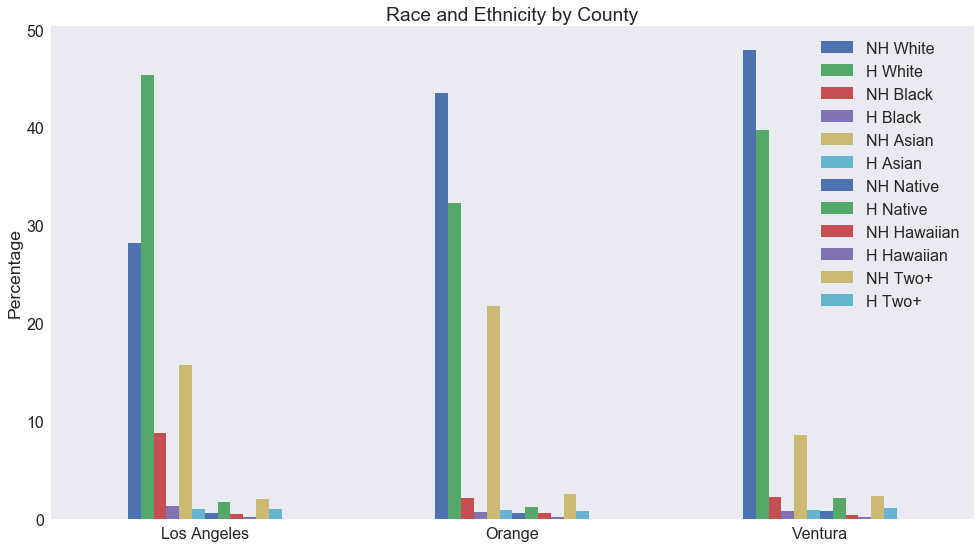

In [334]:
demo3 = demo2.set_index(demo2['County'])
demo3 = demo3.drop(['County'], axis=1)
demo_axes = demo3.plot(kind='bar', grid=False, figsize=(14,8), fontsize=16, rot=0)
demo_axes.set_xlabel('')
demo_axes.set_ylabel('Percentage')
demo_axes.set_title("Race and Ethnicity by County")

The populations aren't as diverse as we'd like, but we think we'll still be able to see some trends. Let's merge this data set with our logerror and environmental data, and check out another correlation heatmap.

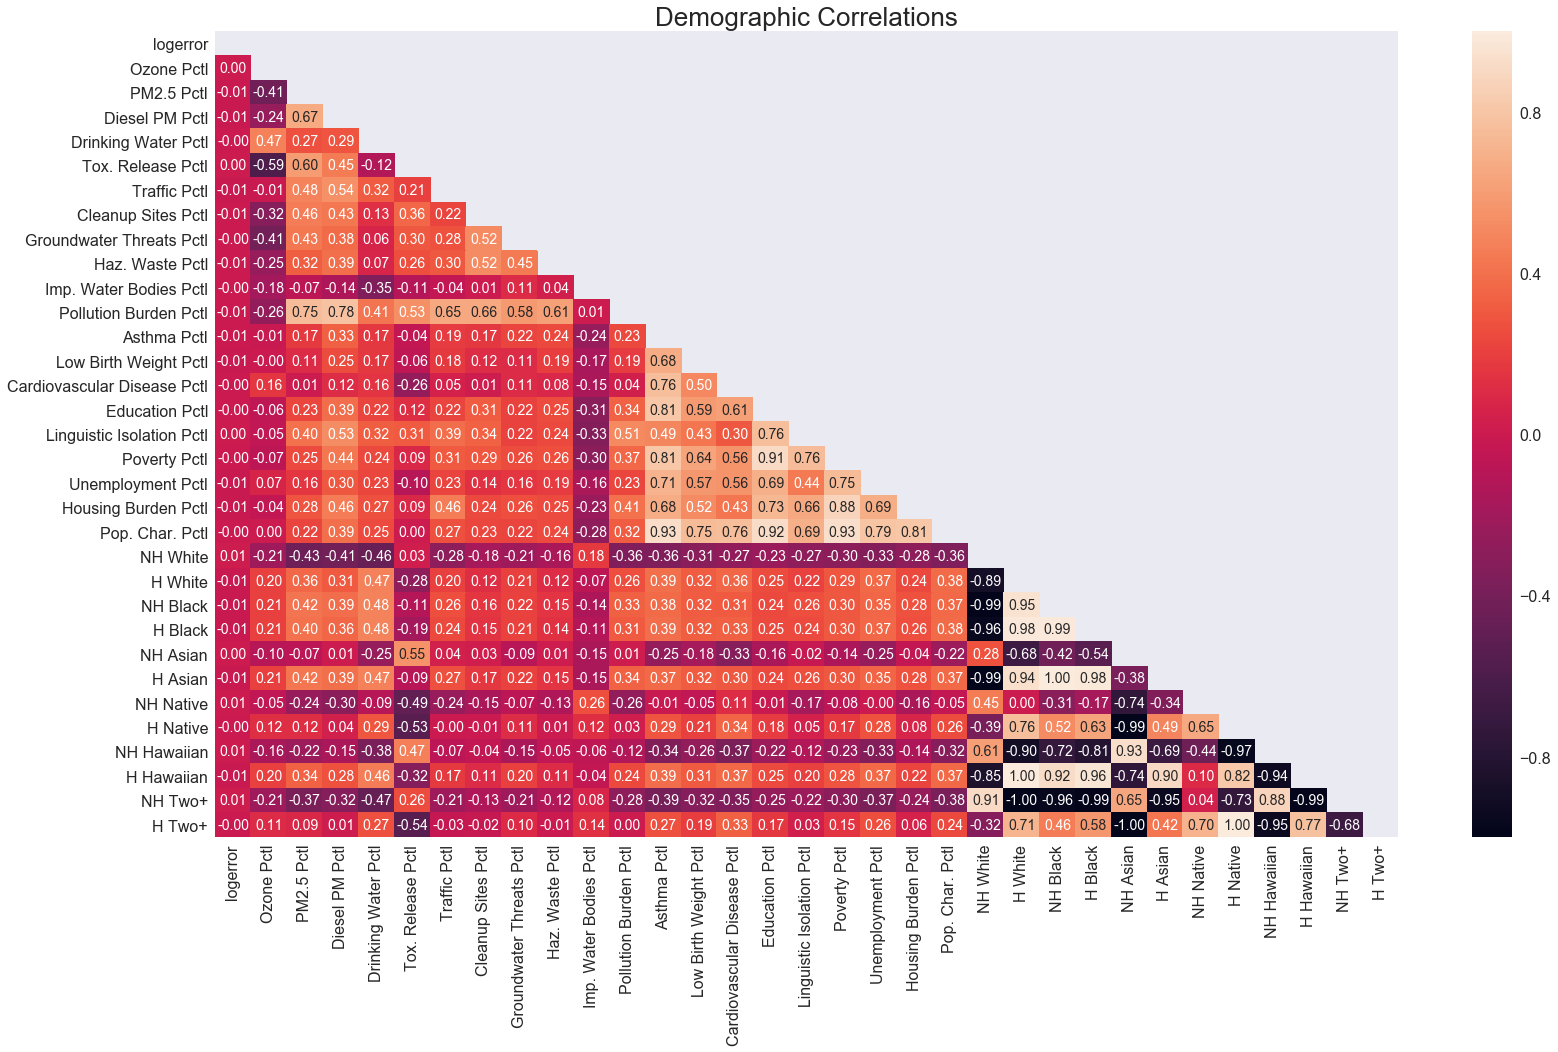

In [9]:
props5 = props3.merge(demo2, on='County', how='left')
props6 = train.merge(props5, how='left', on='parcelid')
props6 = props6.drop(props.columns, axis=1)

df_corr = props6.select(lambda x: not re.search('id', x), axis=1).corr()

# masking the upper right triangle of the heatmap
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# building heatmap
sns.set(font_scale=1.6)
heatmap = sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", annot_kws={"size": 14},
                      xticklabels=True,yticklabels=True)
heatmap.set_title("Demographic Correlations", fontsize=26)
heatmap.figure.set_size_inches(24, 15)

As expected, we still have not found any strong correlations between logerror and any variable, but this chart does reveal some interesting (and some unfortunate) statistics. Let's take a closer look at the correlations with logerror and pick a few variables to use in our model.

In [10]:
print(df_corr['logerror'].sort_values()[:3])
print(df_corr['logerror'].sort_values(ascending=False)[:3])

Diesel PM Pctl   -0.013004
H Asian          -0.011734
NH Black         -0.011646
Name: logerror, dtype: float64
logerror    1.000000
NH White    0.011886
NH Two+     0.010553
Name: logerror, dtype: float64


Viewing the top 3 lowest and highest correlations (aside from logerror) we can pick 4 variables to include in our final model. From this list, it would appear that Diesel PM Pctl, NH White, H Asian, and NH Black would be the best variables to use.

In [26]:
# variables we used in HW2 that got the best results including external data variables
ext_col=['yearbuilt', 'unitcnt', 'finishedsquarefeet6', 'yardbuildingsqft26', 'parcelid', 'Diesel PM Pctl',
        'NH White', 'H Asian', 'NH Black']
ext_df = props5[ext_col]
ext_df.to_csv('ext_vars.csv', index=False)

Next we'll merge them with training data and impute the missing values so that we can incorporate them into a regression model.

In [33]:
#ext_df = pd.read_csv('ext_vars.csv')

# merging external data with training set
ext_df2 = train.merge(ext_df, how='left', on='parcelid').drop(['parcelid', 'transactiondate'], axis=1)

# imputing median values
ext_df3 = ext_df2.fillna(ext_df2.median())
ext_pred = ext_df.drop(['parcelid'], axis=1).fillna(ext_df.median())

# setting up training and pred data
ext_X = ext_df3.drop(['logerror'],axis=1)
ext_y = ext_df3['logerror']

Since RidgeCV was our best model (see the Improved Model section), we utilized the same model but also included the 4 external variables.

In [35]:
# Tuning alphas with RidgeCV
rrcv_ext = RidgeCV(alphas=np.arange(0.1, 10.0, 0.1), scoring='neg_mean_absolute_error', normalize=True).fit(ext_X, ext_y)
print (rrcv_ext.alpha_)

9.9


Finally, we make our predictions and submit them to Kaggle for scoring.

In [36]:
# making predictions
pred_data = np.round(rrcv_ext.predict(ext_pred), 4)

# creating an empty array then filling it with data
pred_mat = np.empty((6,len(pred_data)))
for i in range(6):
    pred_mat[i] = pred_data
    
# need to reshape the matrix
pred_mat = pred_mat.transpose()

# creating the data frame and re-ordering columns
df_sub = pd.DataFrame(pred_mat, index=ext_df.index, columns=['201610', '201611', '201612', '201710', '201711', '201712'])
df_sub['ParcelId'] = ext_df['parcelid']
df_sub = df_sub[['ParcelId','201610', '201611', '201612', '201710', '201711', '201712']]                                                  
df_sub.to_csv('submission_ridge_ext.csv', index=False)

This submission scored 0.0651559 vs. 0.0651594 the same model without external data, so technically it improved the prediction model by a very small amount. In fact, this was our best performing model out of all our submissions.

## Report

In this task, we chose to integrate two data sets consisting of environmental and demographic data into our prediction model. Both of these were location based data sets, and each contained location data that was not included in our properties data set. The primary challenge of this task became generating columns in the properties data set that we could merge the external data sets on.

The properties data set included a column called "regionidzip", which were some unknown ID numbers and not the actual U.S. postal zip codes. This was the same case for the counties, which were ID encoded as some numbers in "regionidcounty". Luckily, in the properties data set we had latitude and longitude coordinates, in the environmental data set we had actual U.S. postal zip codes with their corresponding counties, and in the demographic data set we had only counties. After a great deal of effort, we developed a method that incorporated reverse geocoding to generate U.S. postal zip codes from the properties data set's latitude and longitude coordinates in a fairly accurate manner. We were then able to merge the properties and environmental data set on these zip codes and bring along the counties, which allowed us to then merge the demographics data set on the counties. There was also a great deal of data munging that took place before the merging, and it took a lot of work overall to get them to fit together nicely, which we suppose is the overall lesson of this task.

In the end, we chose 4 variables to incorporate into our final prediction model based on their correlation with logerror: Diesel PM Pctl, NH White, H Asian, and NH Black. All of the correlations were very weak, with Disel PM Pctl having the best of a whopping -0.013004. We definitely suspected that some form of environmental data would affect property value, so it's no surprise that the amount of diesel emissions in an area had the most significant effect. The demographic data is a little more difficult to analyze, and may be pure coincidence considering how low the correlations were. Allthough, if we view the correlation heatmap between the environmental and demographic variables, we can see that certain ethnicity and races tend to correlate with several similar "negative" or "positive" variables, so it would be safe to conclude that a neighborhood's demographics can be used to predict many property variables. Since Zillow did not include demographics in their data set, it makes sense that we were able to slightly improve our predictions by incorporating them into model.

# Improved Model

## Lasso Regression

We'll start our building a Lasso regression model, which was successful in HW2, except this time we will use LassoCV since it includes some hyper-parameter optimization functionality. We will also use the following function to impute variables using Linear Regression, which was successful in HW2 as well.

In [66]:
# this function should impute the variables and return the original dataframe with the imputed series added
def imputeVar(df, var):
    # imputing median values onto x vars
    imputed = df
    for i in df.columns:
        if ~(i == var):
            df[i] = df[i].fillna(df[i].median())
    df_x = df.dropna()
    df_y = df_x[var]
    df_x = df.drop(var, axis=1) 
    
    # splitting training and test data
    x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, random_state=1)

    # train model
    reg_model = LinearRegression()
    reg_model.fit(x_train, y_train)
    
    # split out null values 
    is_null = pd.DataFrame(df_model[df_model[var].isnull()][var])
    pred = pd.DataFrame(df_x, index=is_null.index)
    not_null = pd.DataFrame(df_model[df_model[var].notnull()][var])
    
    # impute null values via regression
    imp = pd.DataFrame(reg_model.predict(pred), index=is_null.index, columns=[var])    
    imp = imp.append(not_null)
    imp = imp.sort_index()
    imputed[var] = imp
    
    return imputed

In [15]:
# variables we used in HW2 that got the best results
corr_col=['yearbuilt', 'unitcnt', 'finishedsquarefeet6', 'yardbuildingsqft26', 'parcelid']
df_model = props[corr_col]

# imputing all missing values
df_model2 = df_model.drop(['parcelid'],axis=1)
#for x in df_model2.columns:
    df_model2 = imputeVar(df_model2, x)
df_model2['parcelid'] = df_model['parcelid']
df_model2.to_csv('imp_vars2.csv', index=False)

In [69]:
df_model2 = pd.read_csv('imp_vars1.csv')

# merging props and training data
df_model3 = train.merge(df_model2, how='left', on='parcelid').drop(['parcelid','transactiondate'], axis=1)

X = df_model3.drop(['logerror'],axis=1)
y = df_model3['logerror']
pred = df_model2.drop(['parcelid'], axis=1)

In [70]:
lscv = LassoCV().fit(X, y)

#the best alpha is lscv.alpha_
print (lscv.alpha_)

0.00276712920017


In [158]:
# making predictions
pred_data = np.round(lscv.predict(pred), 4)

# creating an empty array then filling it with data
pred_mat = np.empty((6,len(pred_data)))
for i in range(6):
    pred_mat[i] = pred_data
    
# need to reshape the matrix
pred_mat = pred_mat.transpose()

# creating the data frame and re-ordering columns
df_sub = pd.DataFrame(pred_mat, index=df_model.index, columns=['201610', '201611', '201612', '201710', '201711', '201712'])
df_sub['ParcelId'] = df_model['parcelid']
df_sub = df_sub[['ParcelId','201610', '201611', '201612', '201710', '201711', '201712']]                                                  
df_sub.to_csv('submission_lasso_1.csv', index=False)

## Ridge Regression

In [71]:
# Tuning alphas with RidgeCV
rrcv = RidgeCV(alphas=np.arange(60.7, 60.8, 0.001), scoring='neg_mean_absolute_error', normalize=True).fit(X, y)
print (rrcv.alpha_)

60.7


In [184]:
# making predictions
pred_data = np.round(rrcv.predict(pred), 4)

# creating an empty array then filling it with data
pred_mat = np.empty((6,len(pred_data)))
for i in range(6):
    pred_mat[i] = pred_data
    
# need to reshape the matrix
pred_mat = pred_mat.transpose()

# creating the data frame and re-ordering columns
df_sub = pd.DataFrame(pred_mat, index=df_model.index, columns=['201610', '201611', '201612', '201710', '201711', '201712'])
df_sub['ParcelId'] = df_model['parcelid']
df_sub = df_sub[['ParcelId','201610', '201611', '201612', '201710', '201711', '201712']]                                                  
df_sub.to_csv('submission_ridge_2.csv', index=False)

## Report

Our attempt to improve our model was successful with respect to our training/test data splits with all models outperforming the basic Ordinary Least Squares which was our baseline from HW2 as the best performing model.  Unfortunately, we were unable to score better than our model in HW2 on Kaggle.  We include some possible rationales for this failure later in our report.

We had all used different techniques in HW2 and our HW3 approach was a synthesis of our previous efforts.  From Tyler's model we took a regression based imputation scheme which showed positive predictive power on our dataset.  From Noushin we took her carefully extracted features which had performed the best on HW2 out of all our models.  Tim's code provided z-score normalization and other cleaning techniques.  Finally, we integrated the ideas of constrained regression using Lasso and Ridge Regression from both Tim and Tyler.

In previous attempts we manually cross validated our training data into test/train/val splits to tune our hyperparameters for Lasso and Ridge Regression.  For this assignment we used the built-in learning functions LassoCV and RidgeCV to fit our data.  We found that the $\alpha$ for Lasso was 002766712920023 while the $\alpha$ for Ridge Regression was over 60.  However for RidgeCV was had to provide a range of values to perform grid search over, which gave our less precise hyperparameter.

Our most successful model was Ridge Regression using external dataset features.  The features we chose were based on viewing the top 3 lowest and highest correlations (aside from logerror).  We eventually picked four variables to include in our final model.  From the original extracted list of features, it would appear that [Diesel PM Pctl, NH White, H Asian, NH Black] were the best variables to use from our analysis.  We see that the most important features were determined to be population metrics.

Ridge Regression works by constraining the space of possible coefficient (weight) vectors for the solution of ordinary least squares via the $\ell_2$ norm.  This constrained optimization formulation results in weight vectors which behave in a more interpretable manner when reducing the values relatively.  Generally this constrained optimization is not solvable in closed form as OLS is.  Thus we need to resort to approximate gradient based methods to determine the optimal weight vector.

What was the most interesting is that our best model was the one which incorporated our external dataset features.  In our analysis of correlation, we did not observe strong correlations between our external features and the log error.  In fact, our features were not correlated at all with the log error.  Despite these results, the incorporation of these external features proved to be a fruitful enterprise for our model.

We considered using the results from Scoring and Clustering as part of our evaluation scheme.  Ultimately we decided that the scoring function would not add any meaningful difference to the output of our learner.  This is due to the fact that our learner operates via linear combinations, and our scoring function was also linear.  We also decided that the scoring function did not capture the variability in the log error.  For these reasons we did not include the scoring function as part of our features but instead used Noushin’s selected features.

The reason we did not include our clustering results as features (using the cluster $c_i$ as a categorical or one-hot vector) was for a similar reason as Scoring.  The cluster regions were decided based on a distance function which was composed of a geographical component and a scoring component.  Although geographical data may have been useful, we already captured some level of this data using our external dataset and region identifiers.  Additionally, the parameter $k$ of clustering determines the results too strongly.  This would normally not be a huge issue, however $k$ is an ill-defined parameter such that we cannot have an optimal $k$ in many respects.  Thus, we chose to use clustering, scoring, and distance mainly as tools for analyzing our parametric space rather than as fully dependent features.

During the course of improving our model we faced many difficulties.  One of the main difficulties was in integrating our Jupyter notebooks successfully.  Due to the many different dependencies and variable naming conventions we found it to be a non-trivial task to sort out what exactly was the correct training set and etc.  This taught us an important lesson about version control that we will consider for future work.

Unfortunately, we did not perform better than our best model for HW2 on Kaggle’s leaderboard.  This is surprising since our models that we chose as HW3 submissions should theoretically be much stronger than the HW2 models.  We used the same features but better learning algorithms.  We also incorporated stronger features from external data which empirically proved effective on our local machines.  Our imputation schemes were improved as well.  

Ultimately, we are not entirely sure why our model for HW3 did not perform as well as for HW2.  One major difference is the training set.  Since we are in phase 2 of the competition we are now working with an updated training set, which means that our models may have superficially performed better in HW2 due to the space which we were learning in.

Our permutation testing showed us that our models did not model the data well.  This can be seen by the fact that random permutations tended to show better results in all three of our models.  It is unclear if this is due to our models being poor, or if this is a feature of the problem space we are working in.  The practice of plotting the permutation test results did however shed more light onto our processes.  We will incorporate this tool as a step in our pipelines in the future.

Trying to improve our models was a humbling experience.  We tried many different approaches, integrating the best aspects of each of our individual efforts into a single cohesive model.  In the end we were unable to outperform our baseline.  Given more time we would have liked to investigate more rigorously how the dataset changed by plotting relative correlations.  We also would investigate more cutting edge machine learning models and kernels which were uploaded to Kaggle.

# Permutation Test

In [67]:
from sklearn.model_selection import permutation_test_score

sampleX_ext = ext_X[1:1000].values
sampleY_ext = ext_y[1:1000]

# External Data RidgeCV
score_ext, permutation_scores_ext, pvalue_ext = permutation_test_score(rrcv_ext, sampleX_ext, sampleY_ext, 
                                scoring="neg_mean_absolute_error", cv=None, n_permutations=100, n_jobs=-1)
print("Classification score %s (pvalue : %s)" % (score_ext, pvalue_ext))

Classification score -0.0658822518356 (pvalue : 1.0)


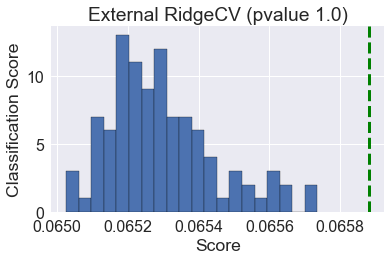

In [99]:
plt.hist(-1 * permutation_scores_ext, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot([-1 * score_ext, -1 * score_ext], ylim, '--g', linewidth=3)
plt.ylim(ylim)
plt.ylabel('Classification Score')
plt.xlabel('Score')
plt.title('External RidgeCV (pvalue %s)' % pvalue_ext)
plt.show()

In [72]:
# from properties data set only
sampleX = X[1:1000].values
sampleY = y[1:1000]

# LassoCV
score_l, permutation_scores_l, pvalue_l = permutation_test_score(lscv, sampleX, sampleY, 
                                scoring="neg_mean_absolute_error", cv=None, n_permutations=100, n_jobs=-1)
print("Classification score %s (pvalue : %s)" % (score_l, pvalue_l))

Classification score -0.0658907320227 (pvalue : 0.930693069307)


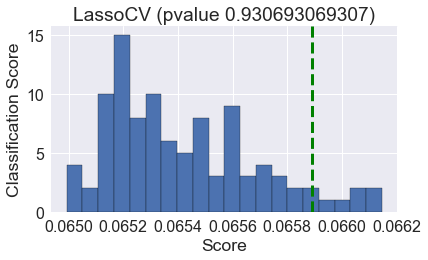

In [98]:
plt.hist(-1 * permutation_scores_l, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot([-1 * score_l, -1 * score_l], ylim, '--g', linewidth=3)
plt.ylim(ylim)
plt.ylabel('Classification Score')
plt.xlabel('Score')
plt.title('LassoCV (pvalue %s)' % pvalue_l)
plt.show()

In [73]:
# RidgeCV
score_r, permutation_scores_r, pvalue_r = permutation_test_score(rrcv, sampleX, sampleY, 
                                scoring="neg_mean_absolute_error", cv=None, n_permutations=100, n_jobs=-1)
print("Classification score %s (pvalue : %s)" % (score_r, pvalue_r))

Classification score -0.0653771060616 (pvalue : 0.811881188119)


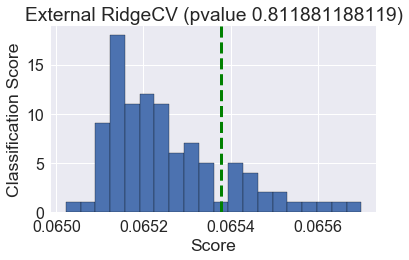

In [100]:
plt.hist(-1 * permutation_scores_r, 20, label='Permutation scores', edgecolor='black')
ylim = plt.ylim()
plt.plot([-1 * score_r, -1 * score_r], ylim, '--g', linewidth=3)
plt.ylim(ylim)
plt.ylabel('Classification Score')
plt.xlabel('Score')
plt.title('External RidgeCV (pvalue %s)' % pvalue_r)
plt.show()